Cell 1 
Import Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

Cell2
Load Train and Test Data

In [9]:
train_path = "../data/manipulated_data_set/train_data.csv"
test_path  = "../data/manipulated_data_set/test_data.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("train set shape:", train_df.shape)
print("test set shape:", test_df.shape)

train_df.head()

train set shape: (1488, 23)
test set shape: (638, 23)


,AC,FM,UC,DL,DS,DP,LB,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,8.0,0.0,2.0,1.0,0.0,0.0,131.0,54.0,1.5,0.0,...,169.0,7.0,0.0,151.0,142.0,147.0,22.0,1.0,2.0,1.0
1,0.0,0.0,4.0,0.0,0.0,0.0,142.0,44.0,0.8,1.0,...,158.0,1.0,0.0,145.0,146.0,147.0,2.0,0.0,1.0,1.0
2,2.0,0.0,6.0,5.0,0.0,0.0,137.0,27.0,1.6,0.0,...,167.0,2.0,0.0,144.0,136.0,141.0,23.0,1.0,6.0,1.0
3,0.0,4.0,1.0,1.0,0.0,0.0,138.0,55.0,0.7,0.0,...,151.0,4.0,0.0,144.0,140.0,143.0,5.0,1.0,1.0,1.0
4,1.0,6.0,0.0,0.0,0.0,0.0,129.0,47.0,0.9,0.0,...,156.0,6.0,0.0,133.0,133.0,134.0,4.0,1.0,3.0,1.0


Cell3
Split Features and Labels

In [20]:
target_col = "NSP"

X_train = train_df.drop(columns=["NSP", "CLASS"])
y_train = train_df["NSP"] - 1  # Adjust labels to start from 0

X_test = test_df.drop(columns=["NSP", "CLASS"])
y_test = test_df["NSP"] - 1  # Adjust labels to start from 0

print("Train feature shape:", X_train.shape)
print("Test feature shape:", X_test.shape)
print("Label distribution (train):")
print(y_train.value_counts())

Train feature shape: (1488, 21)
Test feature shape: (638, 21)
Label distribution (train):
NSP
0.0    1159
1.0     194
2.0     135
Name: count, dtype: int64


Cell4
Define and Train XGBoost Model

In [21]:
xgb_model = XGBClassifier(
    n_estimators=200,         # number of trees
    max_depth=6,              # max depth of each tree
    learning_rate=0.1,        # learning rate
    subsample=0.8,            # sample ratio of the training instances
    colsample_bytree=0.8,     # subsample ratio of columns when constructing each tree
    objective="multi:softprob",  # multi-class classification
    num_class=len(np.unique(y_train)), # number of classes(N,S,P)
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Cell5
Predict and Evaluate

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       496
     Suspect       0.91      0.85      0.88       101
  Pathologic       0.89      0.98      0.93        41

    accuracy                           0.96       638
   macro avg       0.92      0.93      0.93       638
weighted avg       0.96      0.96      0.96       638



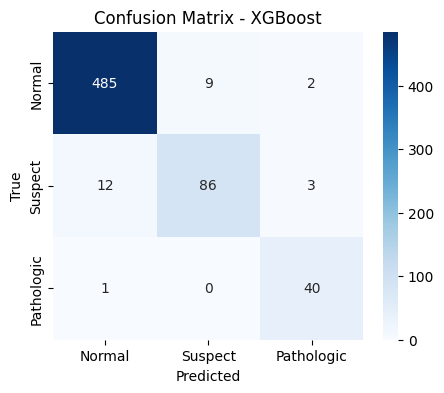

In [22]:
# importance plot
y_pred = xgb_model.predict(X_test)

# Predict probabilities for ROC AUC
y_pred_proba = xgb_model.predict_proba(X_test)

# clssification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Suspect", "Pathologic"]))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Suspect", "Pathologic"], yticklabels=["Normal", "Suspect", "Pathologic"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Cell6
ROC-AUC

Overall ROC-AUC (OvR): 0.9877681388213109


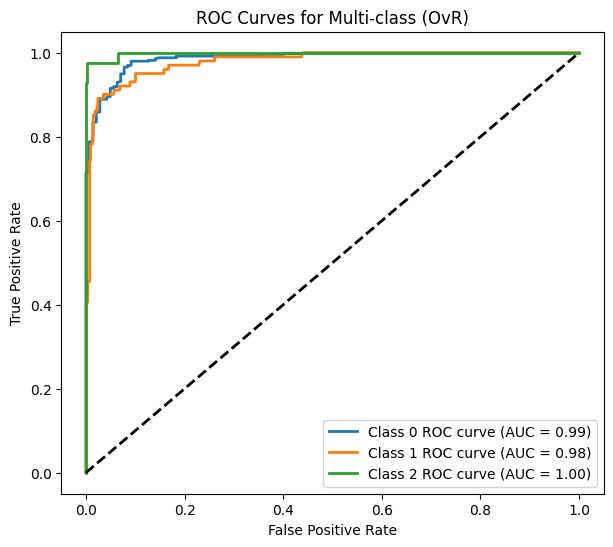

In [23]:
# calculate overall ROC-AUC using One-vs-Rest (OvR) approach
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
print("Overall ROC-AUC (OvR):", roc_auc)

# transform y_test to binary format for each class
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# draw muti-class ROC curves
plt.figure(figsize=(7,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} ROC curve (AUC = {roc_auc_i:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-class (OvR)")
plt.legend(loc="lower right")
plt.show()

Cell7
Feature Importance

<Figure size 1200x600 with 0 Axes>

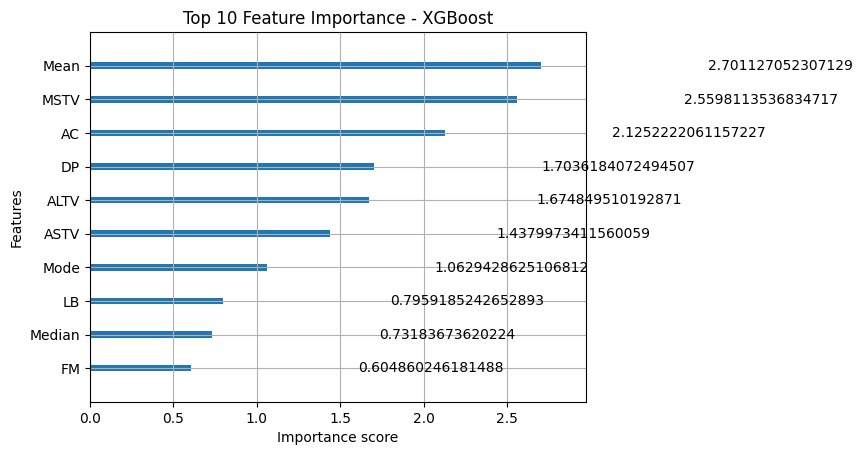

In [25]:
# feature importance plot
plt.figure(figsize=(12,6))
plot_importance(xgb_model, max_num_features=10, importance_type="gain")
plt.title("Top 10 Feature Importance - XGBoost")
plt.show()